In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
from io_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm

sns.set_context("talk")

ibl_data_path = '../data_IBL'
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
myFeatures = [['bias','contrast right','contrast left', 'previous choice', 'previous reward'],['bias','signed stimulus', 'previous choice', 'previous reward']]


In [2]:
# NO LONGER WORKING, FIND NEW WAY TO DONWLAOD DATA


# # Downloading data, then unzipping manually in folder, then preprocessing with below code, adapted from Psytrack notebook (Roy et al., 2021)

# current_cwd = os.getcwd()
# SPATH = current_cwd 
# ibl_data_path = SPATH + '/../data_IBL'
# os.chdir(ibl_data_path)
# print(os.getcwd())

# !pip install ibllib
# # !wget -nc -O "{SPATH}ibl-behavior-data-Dec2019.zip" "https://ndownloader.figshare.com/files/21623715"
# # !unzip -d "{SPATH}" -n "{SPATH}ibl-behavior-data-Dec2019.zip"

# from ibllib import ONE


# import subprocess

# def runcmd(cmd, verbose = False, *args, **kwargs):

#     process = subprocess.Popen(
#         cmd,
#         stdout = subprocess.PIPE,
#         stderr = subprocess.PIPE,
#         text = True,
#         shell = True
#     )
#     std_out, std_err = process.communicate()
#     if verbose:
#         print(std_out.strip(), std_err)
#     pass

# runcmd('echo "Hello, World!"', verbose = True)

# runcmd("wget https://ndownloader.figshare.com/files/21623715", verbose = True)

# # Search all sessions that have these dataset types.
# required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
#                  '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
# one = ONE()
# eids = one.search(required_vars)

# mouseData = pd.DataFrame()
# for eid in eids:
#     lab, _, subject, date, session = eid.split("/")    
#     sess_vars = {
#         "eid": eid,
#         "lab": lab,
#         "subject": subject,
#         "date": date,
#         "session": session,
#     }
#     mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

# all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
# df = pd.DataFrame()

# all_mice = []
# for j, s in enumerate(mouseData["subject"].unique()):
#     print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
#     mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
#     for i, row in mouse.iterrows():
#         myVars = {}
#         for v in all_vars:
#             filename = "_ibl_trials." + v + ".npy"
#             var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
#             myVars[v] = list(np.load(var_file).flatten())

#         num_trials = len(myVars[v])
#         myVars['lab'] = [row.lab]*num_trials
#         myVars['subject'] = [row.subject]*num_trials
#         myVars['date'] = [row.date]*num_trials
#         myVars['session'] = [row.session]*num_trials

#         all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
# df = pd.concat(all_mice, ignore_index=True)

# df = df[df['choice'] != 0]        # dump mistrials
# df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
# df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
# df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
# df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
# df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
# df["correctSide"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
# df.loc[df["correctSide"]==1, "correctSide"] = 0
# df.loc[df["correctSide"]==-1, "correctSide"] = 1
# df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
# df.loc[df["choice"]==1, "choice"] = 0
# df.loc[df["choice"]==-1, "choice"] = 1
# df.to_csv(SPATH+"ibl_processed.csv", index=False)

In [3]:
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
dfAll.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide
0,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
2,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,1,1
3,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,1,0
4,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,1,0


In [4]:
# only looking at animals from 3 labs (32 total animals)
labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

# removing missing or incomplete animals
if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

In [5]:
# # create data and indices for Sebastian and model fitting
# for idx in range(0, len(subjectsAll)):
#     subject = subjectsAll[idx]
#     x, y, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=True, pTanh=5) # NOT LOOKING AT FULL DATASET
#     N = x.shape[0]
#     presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1) 
#     x_separate, y, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=False, pTanh=5) # NOT LOOKING AT FULL DATASET

#     np.savez(f'../data_IBL/{subject}_data_and_indices_CV_5_folds', x1=x, x2=x_separate, y=y, sessInd=sessInd, presentTrain=presentTrain, presentTest=presentTest)


In [6]:
# # concatanating post-training data across all mice into one global dataset
# firstSubject = 'ibl_witten_02'
# signedStimulus = False
# pTanh = 5
# # create dataset with current pTanh transformation
# firstSubject = 'ibl_witten_02'
# x, y, sessInd, correctSide = get_mouse_design(dfAll, subject=firstSubject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) 
# for subject in subjectsAll:
#     if (subject != firstSubject):
#         xTemp, yTemp, sessIndTemp, correctSideTemp = get_mouse_design(dfAll, subject=subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) 
#         # using all data
#         x = np.concatenate((x,xTemp))
#         y = np.concatenate((y,yTemp))
#         sessInd = sessInd + [i + sessInd[-1] for i in sessIndTemp[1:]]

# np.savez(f'../data_IBL/Data_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}', x=x, y=y, sessInd=sessInd)

signedStimulus = False
pTanh = 0.01
data = np.load(f'../data_IBL/Data_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')
x = data['x']
y = data['y']
sessInd = data['sessInd']
print(x.shape)
print(len(sessInd))

(1755215, 5)
2304


# Standard GLM (1 state) fits with different values of pTanh

In [7]:
pTanhList = [0.01, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
signedStimulus = True

ll = []
for pTanh in pTanhList:
    data = np.load(f'../data_IBL/all_animals/allAnimals_pTanh={pTanh}_GLM_signedStimulus={signedStimulus}.npz')
    ll.append(data['trainLl']) 
    
    # saving p=5 GLM weights

fig, axes = plt.subplots(1, figsize=(12,5))
axes.scatter(pTanhList, ll)
axes.set_ylabel('train log-likelihood (per trial)')
axes.set_xlabel('p (tanh transformation)')
axes.set_title('GLM fits on global dataset with all animals')
    

FileNotFoundError: [Errno 2] No such file or directory: '../data_IBL/all_animals/allAnimals_pTanh=0.01_GLM_signedStimulus=True.npz'

# Standard GLM-HMM 3-state Global fits (p=5 performs better than p=0.01)

In [48]:
def reshape_parameters_per_trial(w, p, sessInd):
    '''  
    Parameters
    ----------

    w: S x K x D x C numpy array
        weights for each session (S total sessions)
    sessInd: list
        indices of first trial for each session (and sessInd[-1]=total number of trials)

    Returns
    -------
    w_reshaped: N x K x D x C
        weights reshaped to have per trial values in each session (constant with session)
    '''

    if len(sessInd) - 1 != w.shape[0]:
        raise Exception("Number of sessions does not match between weights and first trial indices")
    else:
        w_reshaped = np.zeros((sessInd[-1], w.shape[1], w.shape[2], w.shape[3]))
        for i in range(0, len(sessInd)- 1):
            w_reshaped[sessInd[i]:sessInd[i+1]] = w[i]
    
    if len(sessInd) - 1 != p.shape[0]:
        raise Exception("Number of sessions does not match between weights and first trial indices")
    else:
        p_reshaped = np.zeros((sessInd[-1], p.shape[1], p.shape[2]))
        for i in range(0, len(sessInd)- 1):
            p_reshaped[sessInd[i]:sessInd[i+1]] = p[i]
    
    return w_reshaped, p_reshaped

In [8]:
K = 3
inits = 25
D_signed = [5, 4]
Ll_total = np.zeros((2,2))
pTanhList = [0.01, 5]

reorder = [[2,0,1],[0,2,1], [2,1,0], [2,0,1]] # reorder to have consistent meaning of states with labels 1,2,3 (1-engaged, 2-biased right, 3-biased left)
c = 0
for signedStimulus in [False, True]:
    for ind_pTanh in [0,1]:
        pTanh = pTanhList[ind_pTanh]

        Ll_temp = []
        for init in range(0, inits):
            data = np.load(f'../data_IBL/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={init}_signedStimulus={signedStimulus}.npz')
            Ll_temp.append(data['trainLl'])

        ind_best = np.argmax(Ll_temp)
        data_best = np.load(f'../data_IBL/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={ind_best}_signedStimulus={signedStimulus}.npz')
        Ll_total[ind_pTanh, signedStimulus] = data_best['trainLl']
        print(f'Train log-like for ptanh={pTanh} and signed stimulus contrast = {signedStimulus} is ')
        print(np.round(data_best['trainLl'], 4))

        print(data_best["P"][:, reorder[c], :][:, :, reorder[c]][0])
        fig, axes = plt.subplots(1, figsize=(12,5))
        plot_constant_weights(data_best["W"][:, reorder[c]][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
        axes.set_ylabel('weights')
        axes.set_title(f'tanh p={pTanh}')

        # save best standard GLMHMM parameters for global dataset (all animals)
        np.savez(f'../data_IBL/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}', W=data_best["W"][:, reorder[c]], P=data_best["P"][:, reorder[c], :][:, :, reorder[c]])

        c+= 1

        






FileNotFoundError: [Errno 2] No such file or directory: '../data_IBL/allAnimals_standardGLMHMM_3-state_pTanh=0.01_init=0_signedStimulus=False.npz'

# Standard GLM-HMM for 1,2,3,4,5 states respectively (global fits for all animals)

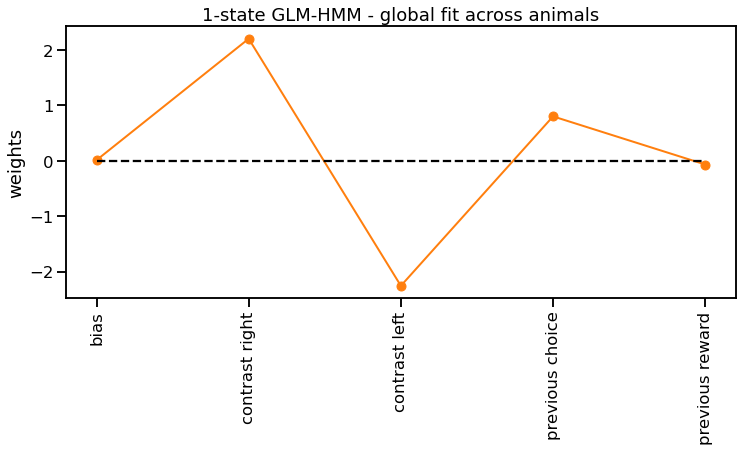

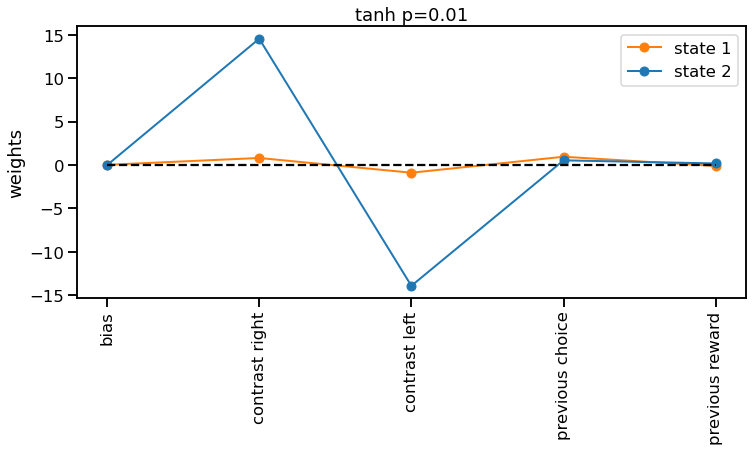

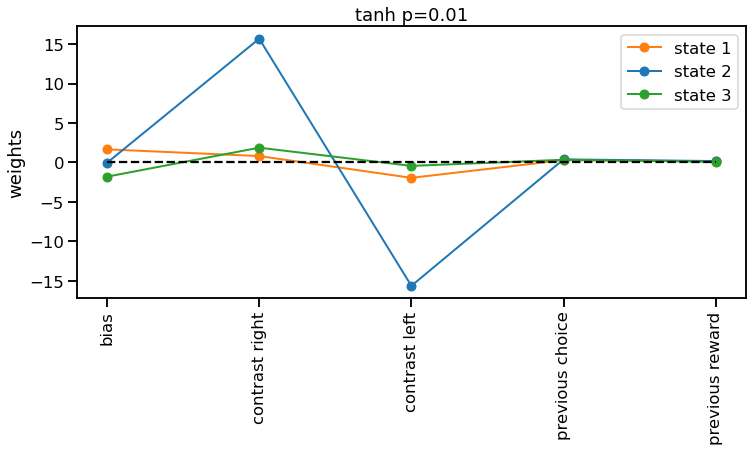

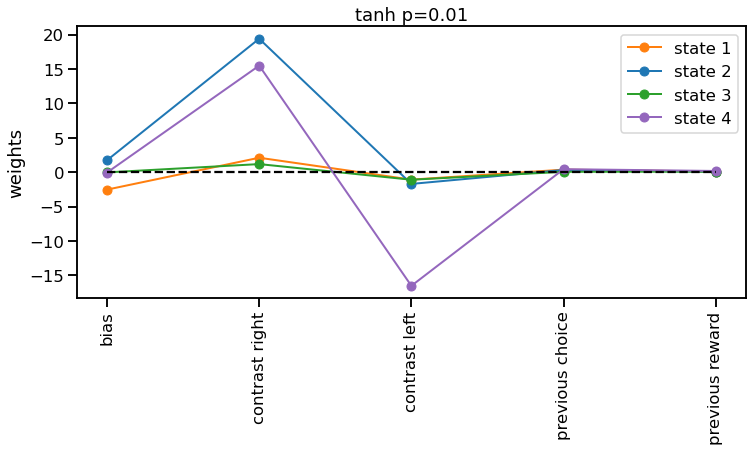

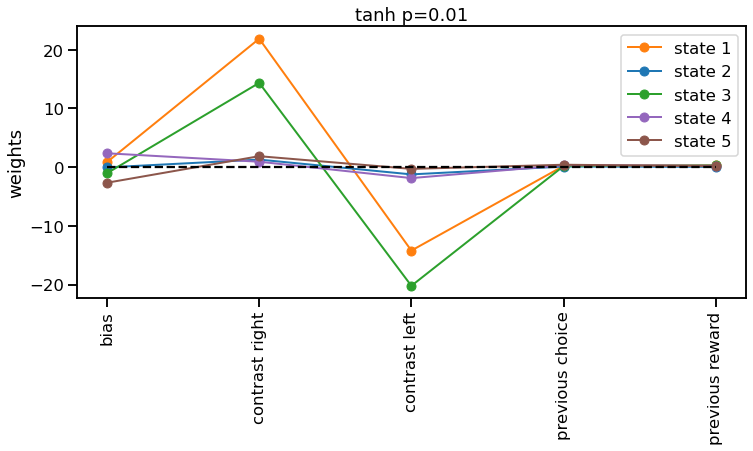

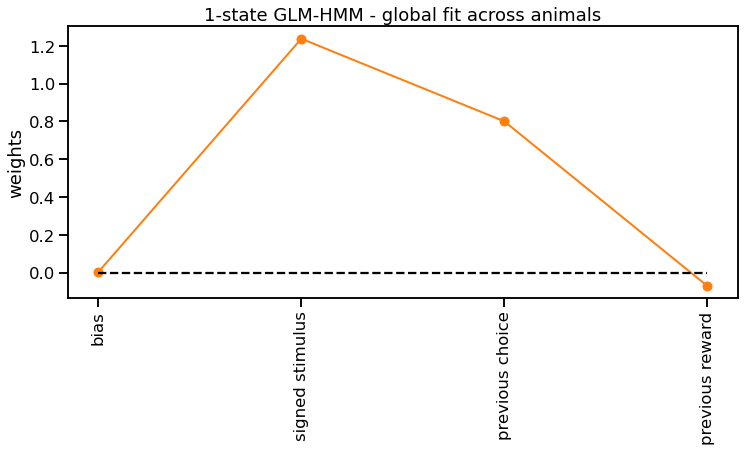

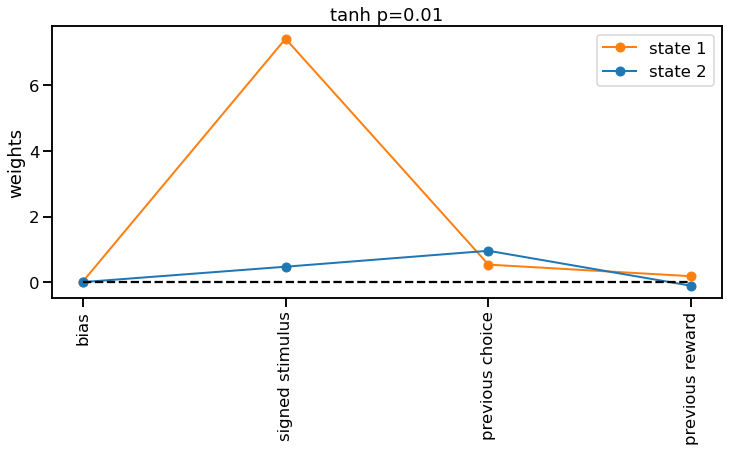

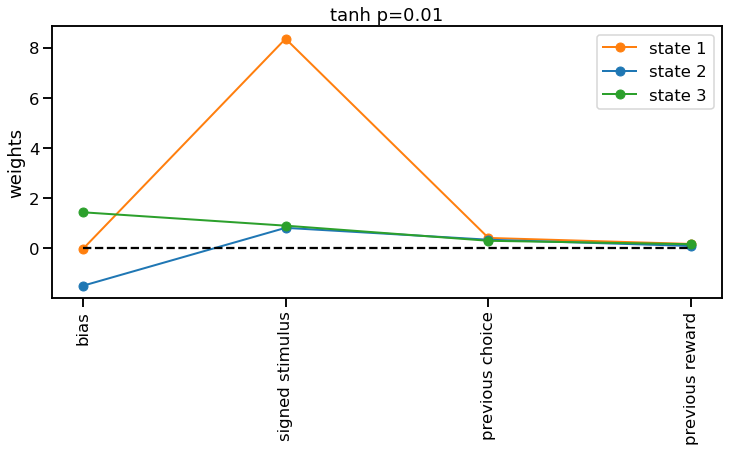

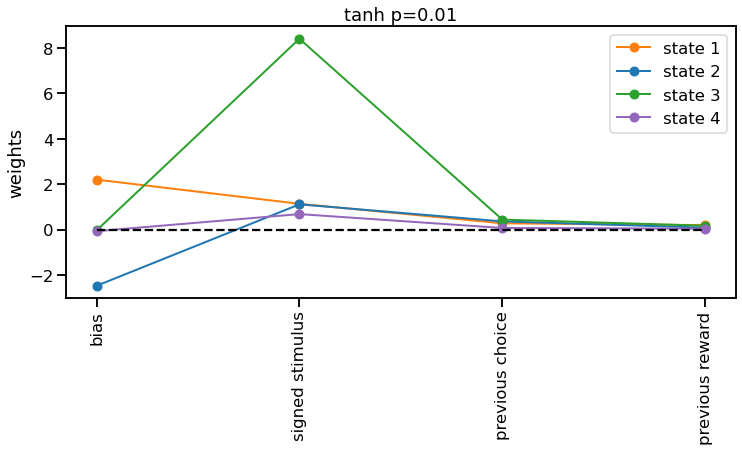

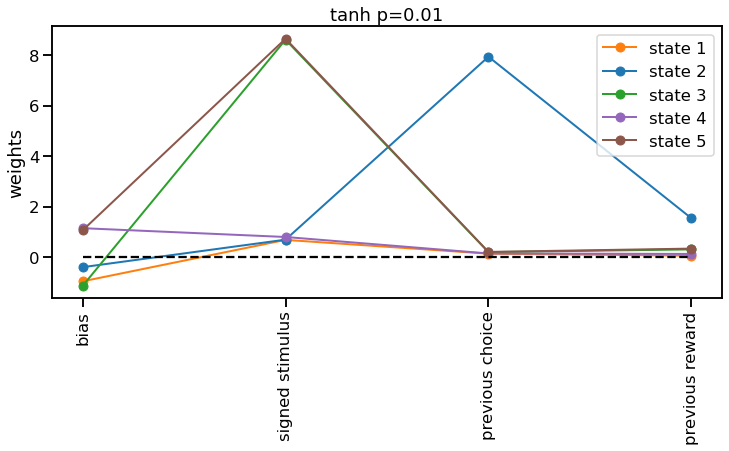

In [15]:
# finding best fit parameters for standard GLM-HMM across all animals

pTanh = 0.01 # performs better than p=0.01 which is equivalent to no tanh transformation
inits = 25

# for pTanh = 5
# reorder state labels to have consistent meaning across models
reorder = {(False, 2): [1,0], (True, 2): [1,0], (False, 3): [0,2,1], (True, 3): [2,0,1], (False, 4): [0,3,2,1], (True, 4): [2,0,1,3], (False, 5): [3,0,2,4,1], (True, 5): [4,3,0,2,1]}
#inits_5_state = [[0,2,4,6,8,10,11,12,14,15,16,17,18,19,20,21,22,23], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
inits_5_state = [[0,1,2,3,4,8,10,13,14,15,16,17,19,20,21,22,23,24], list(range(25))]
for signedStimulus in [False, True]:
    for K in [1,2,3,4,5]:
        if K==1:
            data = np.load(f'../data_IBL/all_animals/allAnimals_pTanh={pTanh}_GLM_signedStimulus={signedStimulus}.npz')
            
            # plotting parameters
            # print(data["P"][0])
            fig, axes = plt.subplots(1, figsize=(12,5))
            plot_constant_weights(data["W"][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
            axes.set_ylabel('weights')
            axes.set_title(f'{K}-state GLM-HMM - global fit across animals')

            # saving parameters
            np.savez(f'../data_IBL/all_animals/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}', P=data['P'], pi=data['pi'], W=data['W'])

        elif K in [2,3,4]: 
            order = reorder.get((signedStimulus, K))

            # finding best initialization
            Ll_temp = []
            for init in range(0, inits):
                data = np.load(f'../data_IBL/all_animals/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={init}_signedStimulus={signedStimulus}.npz')
                Ll_temp.append(data['trainLl'])

            ind_best = np.argmax(Ll_temp)
            data_best = np.load(f'../data_IBL/all_animals/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={ind_best}_signedStimulus={signedStimulus}.npz')

            # plotting parameters
            P_best = data_best["P"][:, order, :][:, :, order]
            W_best = data_best["W"][:, order]
            # print(np.round(P_best, 3)[0])
            fig, axes = plt.subplots(1, figsize=(12,5))
            plot_constant_weights(W_best, axes, labels=myFeatures[signedStimulus], colors=colorsStates)
            axes.set_ylabel('weights')
            axes.set_title(f'tanh p={pTanh}')
            axes.legend()

            # saving parameters
            np.savez(f'../data_IBL/all_animals/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}', P=P_best, pi=data_best['pi'], W=W_best)

        elif K==5: 
            order = reorder.get((signedStimulus, K))

            # finding best initialization
            Ll_temp = {}
            for init in inits_5_state[signedStimulus]:
                data = np.load(f'../data_IBL/all_animals/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={init}_signedStimulus={signedStimulus}.npz')
                Ll_temp[init] = data['trainLl']

            ind_best =  max(zip(Ll_temp.values(), Ll_temp.keys()))[1]
            data_best = np.load(f'../data_IBL/all_animals/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={ind_best}_signedStimulus={signedStimulus}.npz')

            # plotting parameters
            P_best = data_best["P"][:, order, :][:, :, order]
            W_best = data_best["W"][:, order]
            # print(np.round(P_best, 3)[0])
            fig, axes = plt.subplots(1, figsize=(12,5))
            plot_constant_weights(W_best, axes, labels=myFeatures[signedStimulus], colors=colorsStates)
            axes.set_ylabel('weights')
            axes.set_title(f'tanh p={pTanh}')
            axes.legend()

            # saving parameters
            np.savez(f'../data_IBL/all_animals/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}', P=P_best, pi=data_best['pi'], W=W_best)


        

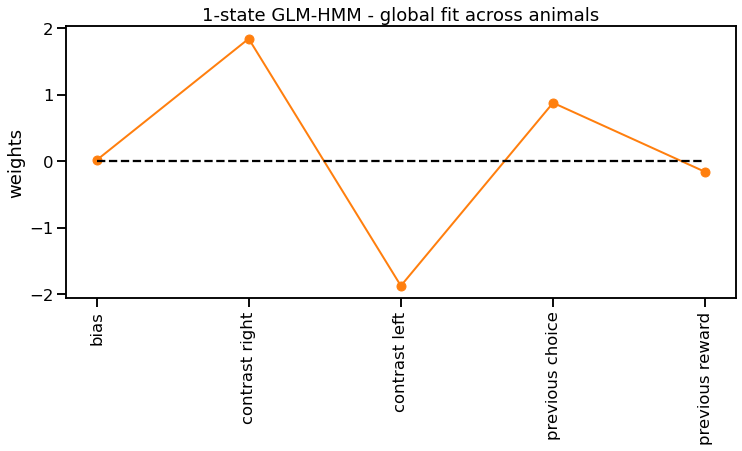

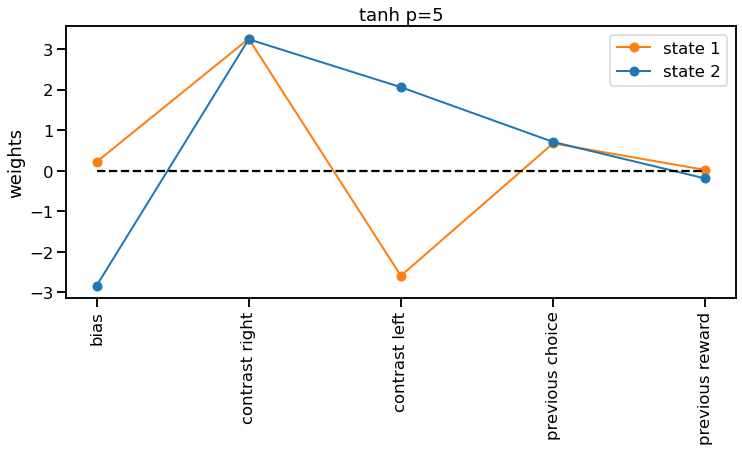

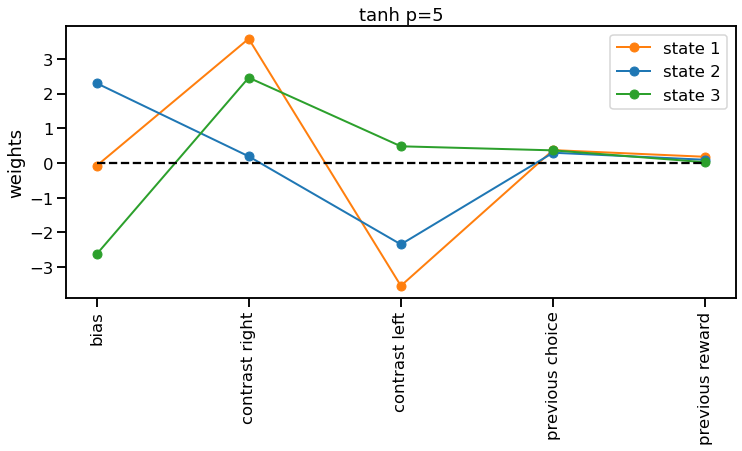

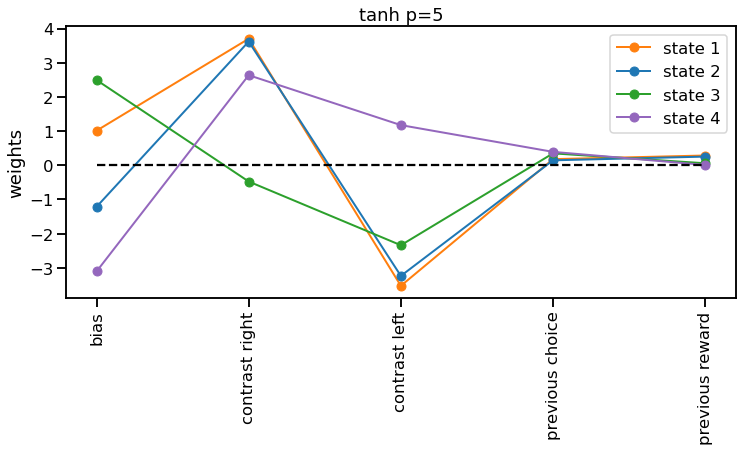

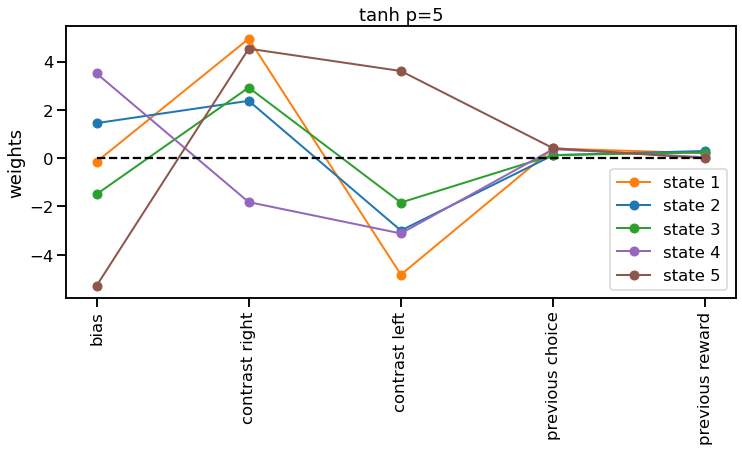

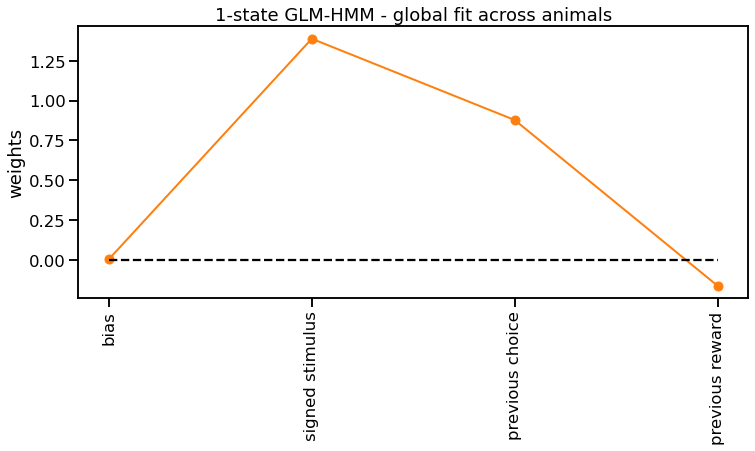

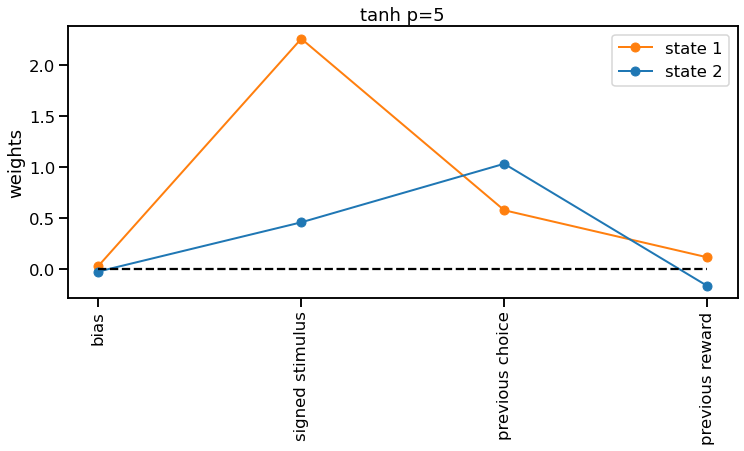

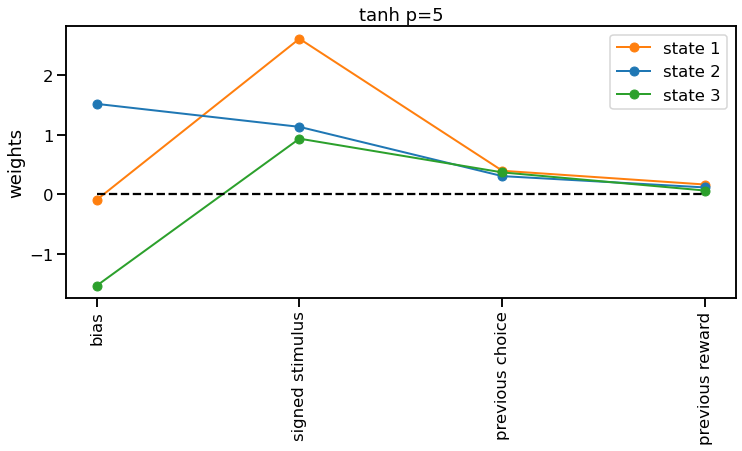

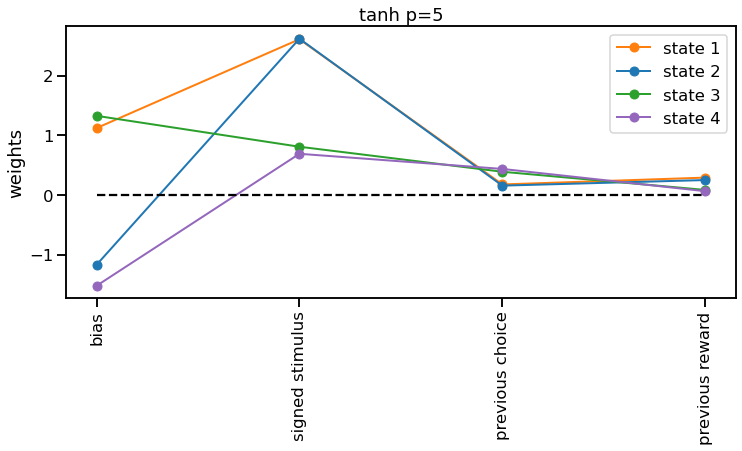

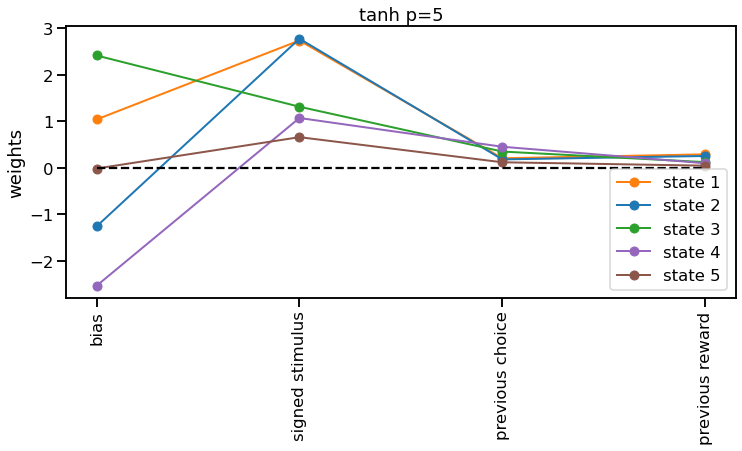

In [10]:
# plotting best fit parameters for standard GLM-HMM across all animals

pTanh = 5 # performs better than p=0.01 which is equivalent to no tanh transformation
inits = 25
# reorder state labels to have consistent meaning across models
# reorder = {(False, 2): [1,0], (True, 2): [1,0], (False, 3): [0,2,1], (True, 3): [2,0,1], (False, 4): [0,3,2,1], (True, 4): [2,0,1,3], (False, 5): [3,0,2,4,1], (True, 5): [4,3,0,2,1]}
inits_5_state = [[0,2,4,6,8,10,11,12,14,15,16,17,18,19,20,21,22,23], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
for signedStimulus in [False, True]:
    for K in [1,2,3,4,5]:
        if K==1:
            data = np.load(f'../data_IBL/all_animals/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')

            # plotting parameters
            # print(data["P"][0])
            fig, axes = plt.subplots(1, figsize=(12,5))
            plot_constant_weights(data["W"][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
            axes.set_ylabel('weights')
            axes.set_title(f'{K}-state GLM-HMM - global fit across animals')

            # saving parameters
            
        elif K in [2,3,4]: 
            data_best =  np.load(f'../data_IBL/all_animals/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')

            # plotting parameters
            P_best = data_best["P"]
            W_best = data_best["W"]
            # print(np.round(P_best, 3)[0])
            fig, axes = plt.subplots(1, figsize=(12,5))
            plot_constant_weights(W_best, axes, labels=myFeatures[signedStimulus], colors=colorsStates)
            axes.set_ylabel('weights')
            axes.set_title(f'tanh p={pTanh}')
            axes.legend()

        elif K==5: 
            data_best = np.load(f'../data_IBL/all_animals/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')

            # plotting parameters
            P_best = data_best["P"]
            W_best = data_best["W"]
            # print(np.round(P_best, 3)[0])
            fig, axes = plt.subplots(1, figsize=(12,5))
            plot_constant_weights(W_best, axes, labels=myFeatures[signedStimulus], colors=colorsStates)
            axes.set_ylabel('weights')
            axes.set_title(f'tanh p={pTanh}')
            axes.legend()

        

# Partial GLM-HMM

(1000, 3, 4, 2)


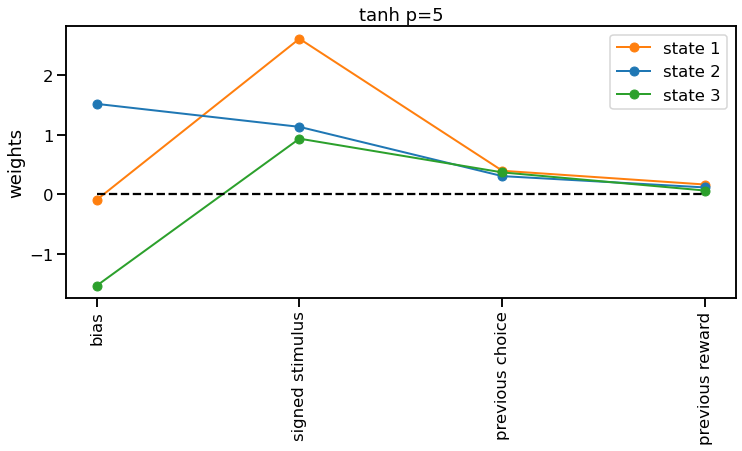

In [35]:
N=1000
sigmaList = [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
D = 4
signedStimulus = True
C=2
pTanh = 5
K = 3

allP = np.zeros((len(sigmaList)+1, N, K, K))
allpi = np.zeros((len(sigmaList)+1, K))
allW = np.zeros((len(sigmaList)+1, N, K, D, C)) 

dGLM_HMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,C)

dataInit = np.load(f'../data_IBL/Best_allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')
glmhmmP = dataInit['P']
glmhmmpi = dataInit['pi']
glmhmmW = dataInit['W']
    
# first one is standard GLM-HMM (sigma=0)
if (glmhmmW is not None and glmhmmP is not None): # if parameters are given from standard GLM-HMM (constant across sessions)
    allpi[0] = np.ones((K)) / K
    allP[0, :] = glmhmmP[0]
    allW[0, :] = glmhmmW[0]

print(allW[0].shape)
fig, axes = plt.subplots(1, figsize=(12,5))
plot_constant_weights(allW[0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
axes.set_ylabel('weights')
axes.set_title(f'tanh p={pTanh}')
axes.legend()